# Preliminary

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass
from types import SimpleNamespace
from dateutil.relativedelta import relativedelta
from typing import NamedTuple

plt.rcParams["figure.figsize"] = (9,6)

BOND_CSV = Path(".") / "bond.csv"
DB_MODEL_CSV = Path(".") / "db_model.csv"
SETTLEMENT_DATE = pd.Timestamp("2025-10-31")
DAY_COUNT = "ACT/ACT"
COMPOUNDING = "cont"  # "cont", "annual", or "semi"

np.random.seed(42)

# Load bond data
bonds = pd.read_csv(
    BOND_CSV,
    sep=";",
    decimal=",",
    encoding="utf-8-sig",
    dayfirst=True,
    parse_dates=["maturity_date"]
)

# Load DB model data
db_model = pd.read_csv(
    DB_MODEL_CSV,
    sep=";",
    decimal=",",
    encoding="utf-8-sig",
    dayfirst=True,
)
db_model["y_model"] = db_model["y_model"].str.rstrip("%").astype(float) / 100

print(bonds)
print(db_model)


   maturity_date  coupon_rate  current_price
0     2004-02-15        3.000       101.0544
1     2004-08-15        2.125       100.9254
2     2005-02-15        1.500        99.8942
3     2005-08-15        6.500       109.0934
4     2006-02-15        5.625       108.4380
5     2006-08-15        2.375        99.7848
6     2007-02-15        6.250       111.7184
7     2007-08-15        3.250       101.0841
8     2008-02-15        3.000        99.1692
9     2008-08-15        3.250        99.2710
10    2009-02-15        5.500       109.7707
11    2009-08-15        6.000       112.1450
12    2010-02-15        6.500       114.9084
13    2010-08-15        5.750       110.3894
14    2011-02-15        5.000       105.2934
15    2011-08-15        5.000       104.7607
16    2012-02-15        4.875       103.4391
17    2012-08-15        4.375        99.2806
18    2013-02-15        3.875        95.0288
19    2013-08-15        4.250        97.7693
20    2014-02-15       13.250       174.3251
21    2014

C:\Users\mc160\AppData\Local\Temp\ipykernel_9188\3389551623.py:21: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  bonds = pd.read_csv(


# Q1 Boostrapping

# Q1.1

Solve  for  the  prices  of  discount  bonds  given  the  market  prices  of  coupon  bonds  and identify the zero-coupon yields from the prices of zero-coupon bonds.

In [4]:
## Helper functions

# Helper function: get frequence from bonds DataFrame
def get_freq(bonds, default=2):
    return int(bonds["frequency"].mode().iloc[0]) if "frequency" in bonds.columns else default

# Helper function: convert coupon rate from provided data to decimal
def _clean_coupon_rate(x):
    x = float(x)
    return x/100.0 if x > 1.0 else x

# Helper function: get price from bonds DataFrame
def get_price(r):
    for c in ("clean_price","current_price","Price","price"):
        if c in r and pd.notna(r[c]):
            return float(r[c])
    return float(r.get("P", np.nan))

# Helper function: compute accrued interest
def compute_accrued(coupon_rate, face, freq, settlement, maturity):
    if settlement >= maturity:
        return 0.0
    period = relativedelta(months=int(12/freq))
    d = maturity
    while d - period > settlement:
        d -= period
    last_coupon = d - period
    next_coupon = d
    days = (next_coupon - last_coupon).days
    elapsed = (settlement - last_coupon).days
    frac = max(0.0, min(1.0, elapsed / days if days>0 else 0.0))
    cpn = coupon_rate/freq * face
    return cpn * frac

# Helper function: ZC yield from DF
def zc_yield_from_df(df, T, comp="cont"):
    df = np.asarray(df, float); T = np.asarray(T, float)
    T = np.maximum(T, 1e-8)
    if comp == "cont":
        return -np.log(df)/T
    if comp in ("annual","ann"):
        return df**(-1.0/T) - 1.0
    if comp in ("semi","semiannual"):
        return 2.0*(df**(-1.0/(2.0*T)) - 1.0)
    raise ValueError("Unknown compounding")

       T        DF      y_zc
0    0.5  0.995610  0.008800
1    1.0  0.988176  0.011894
2    1.5  0.976738  0.015691
3    2.0  0.963406  0.018640
4    2.5  0.947375  0.021624
5    3.0  0.928970  0.024560
6    3.5  0.907564  0.027712
7    4.0  0.887418  0.029860
8    4.5  0.864791  0.032282
9    5.0  0.841559  0.034500
10   5.5  0.819380  0.036220
11   6.0  0.794000  0.038445
12   6.5  0.769343  0.040341
13   7.0  0.746507  0.041764
14   7.5  0.724062  0.043051
15   8.0  0.701204  0.044369
16   8.5  0.680072  0.045360
17   9.0  0.660381  0.046104
18   9.5  0.643389  0.046422
19  10.0  0.627754  0.046561
20  10.5  0.611738  0.046805
21  11.0  0.585340  0.048687
22  11.5  0.546185  0.052591
23  12.0  0.528678  0.053115
24  12.5  0.509846  0.053892
25  13.0  0.492711  0.054449
26  13.5  0.476050  0.054980
27  14.0  0.457551  0.055848
28  14.5  0.444315  0.055946
29  15.0  0.429353  0.056365
30  15.5  0.412853  0.057075
31  16.0  0.398744  0.057465
32  16.5  0.386180  0.057664
33  17.0  0.37

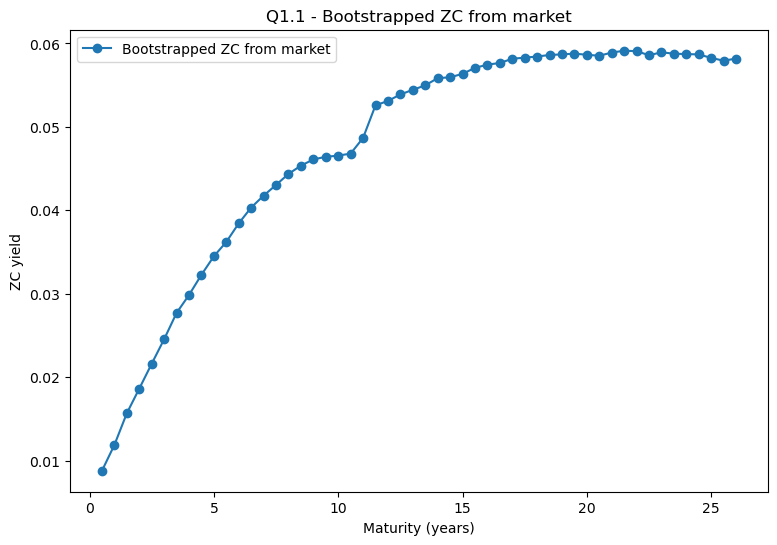

In [5]:
## Boostrapping function

def bootstrap(bonds: pd.DataFrame, settlement=None, compounding="cont", day_count="ACT/ACT", enforce_monotonic=True, clip_eps=1e-10):
    df = bonds.copy().sort_values("maturity_date").reset_index(drop=True)
    n = len(df)
    if n == 0:
        raise ValueError("bonds is empty")

    freq = get_freq(df, 2) # default is set as semi-annual (it as in our assumptions)

    # Settlement by default: 1 period before the first maturity date.
    if settlement is None:
        first = pd.Timestamp(df.loc[0, "maturity_date"])
        settlement = first - relativedelta(months=int(12/freq))
    settlement = pd.Timestamp(settlement)

    period_years = 1.0 / freq

    # Standardisation
    df["coupon_rate"] = df["coupon_rate"].apply(_clean_coupon_rate).astype(float)
    faces = df.get("face", pd.Series([100.0]*n)).astype(float).values
    maturities = [pd.Timestamp(x) for x in df["maturity_date"]]
    prices_clean = np.array([get_price(r) for _, r in df.iterrows()], float)

    # Dirty = clean + accrued (only if clean)
    if "clean_price" in df.columns and "price" not in df.columns:
        prices_dirty = prices_clean.copy()
        for i in range(n):
            ai = compute_accrued(df.loc[i,"coupon_rate"], faces[i], freq, settlement, maturities[i])
            prices_dirty[i] = prices_clean[i] + ai
    else:
        prices_dirty = prices_clean

    # Regular grid
    T = np.arange(1, n+1, dtype=float) * period_years

    # Cash flow matrix
    cpn_per_period = (df["coupon_rate"].values / freq) * faces
    A = np.zeros((n, n), float)
    for i in range(n):
        A[i, :i+1] = cpn_per_period[i]
        A[i, i] += faces[i]

    # Forward substitution (lower triangular system)
    DF = np.zeros(n, float)
    for i in range(n):
        rhs = prices_dirty[i] - float(np.dot(A[i, :i], DF[:i]))
        DF[i] = rhs / A[i, i]

    # Constraints
    if enforce_monotonic:
        DF = np.maximum(DF, clip_eps)
        for i in range(1, n):
            if DF[i] > DF[i-1]:
                DF[i] = DF[i-1]

    y = zc_yield_from_df(DF, T, compounding)
    try:
        return BootstrapResult(maturities=T, dfs=DF, zc_yields=y)
    except NameError:
        # Fallback minimal structure if BootstrapResult absent
        class _BootstrapResult(NamedTuple):
            maturities: np.ndarray
            dfs: np.ndarray
            zc_yields: np.ndarray
        return _BootstrapResult(maturities=T, dfs=DF, zc_yields=y)
    

## Results
bootstrap = bootstrap(bonds, settlement=SETTLEMENT_DATE, compounding=COMPOUNDING, day_count=DAY_COUNT)
mkt_zc = pd.DataFrame({"T": bootstrap.maturities, "DF": bootstrap.dfs, "y_zc": bootstrap.zc_yields})
print(mkt_zc)
mkt_zc.to_csv("q11_bootstrapped_zc_yields.csv", index=False)

# Plot zero-coupon yields
plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", linestyle="-", label="Bootstrapped ZC from market")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q1.1 - Bootstrapped ZC from market")
plt.savefig("q11_bootstrapped_zc_yields.png")
plt.show()

# Q1.2

Compare the zero-coupon yields from Deutsche Bank's model (in Exhibit 4 of the case) to 
the  market  zero-coupon  yields,  and  identify  which  zero-coupon  bonds  Deutsche  Bank should buy, and which ones they should sell. Load the model zero-coupon yields and generate buy/sell signals based on relative value.

In [6]:
# Helper function: DF from ZC yield
def df_from_zc_yield(y, T, comp="cont"):
    y = np.asarray(y, float); T = np.asarray(T, float)
    T = np.maximum(T, 1e-8)
    if comp == "cont":
        return np.exp(-y*T)
    if comp in ("annual","ann"):
        return (1.0 + y)**(-T)
    if comp in ("semi","semiannual"):
        return (1.0 + y/2.0)**(-2.0*T)
    raise ValueError("Unknown compounding")

       T  y_market   y_model  DF_market  DF_model   signal
0    0.5  0.008800  0.012443   0.995610  0.993798  Sell ZC
1    1.0  0.011894  0.012443   0.988176  0.987634  Sell ZC
2    1.5  0.015691  0.015585   0.976738  0.976894   Buy ZC
3    2.0  0.018640  0.018727   0.963406  0.963239  Sell ZC
4    2.5  0.021624  0.021419   0.947375  0.947862   Buy ZC
5    3.0  0.024560  0.024110   0.928970  0.930224   Buy ZC
6    3.5  0.027712  0.026888   0.907564  0.910186   Buy ZC
7    4.0  0.029860  0.029665   0.887418  0.888110   Buy ZC
8    4.5  0.032282  0.032059   0.864791  0.865656   Buy ZC
9    5.0  0.034500  0.034454   0.841559  0.841752   Buy ZC
10   5.5  0.036220  0.036505   0.819380  0.818092  Sell ZC
11   6.0  0.038445  0.038557   0.794000  0.793468  Sell ZC
12   6.5  0.040341  0.040277   0.769343  0.769667   Buy ZC
13   7.0  0.041764  0.041996   0.746507  0.745297  Sell ZC
14   7.5  0.043051  0.043337   0.724062  0.722510  Sell ZC
15   8.0  0.044369  0.044677   0.701204  0.699481  Sell 

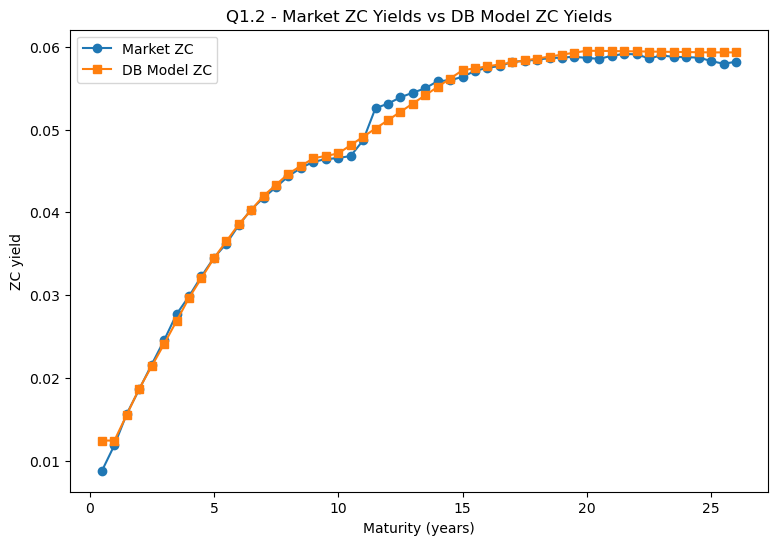

In [7]:
# Comparison market vs DB model

db_sortedT = db_model.sort_values("T")
interpolation = np.interp(mkt_zc["T"].values, db_sortedT["T"].values, db_sortedT["y_model"].values)

# Buy or Sell decision:
# ym>yb => "Buy ZC" 
# versus 
# ym<yb => "Sell ZC"
T = np.asarray(mkt_zc["T"].values, float)
ym = np.asarray(mkt_zc["y_zc"].values, float)
yb = np.asarray(interpolation, float)
df_mkt = df_from_zc_yield(ym, T, COMPOUNDING) # just to check if the prices are consistent with yields decision when buying/selling
df_mod = df_from_zc_yield(yb, T, COMPOUNDING) # just to check if the prices are consistent with yields decision when buying/selling
signal = np.where(ym > yb, "Buy ZC", "Sell ZC")  # market > model => ZC cheap
Comparison = pd.DataFrame({
    "T": T, "y_market": ym, "y_model": yb,
    "DF_market": df_mkt, "DF_model": df_mod,
    "signal": signal
    })
print(Comparison)
Comparison.to_csv("q12_market_vs_db_model_comparison.csv", index=False)

# Plot comparison
plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", label="Market ZC")
plt.plot(mkt_zc["T"], interpolation, marker="s", label="DB Model ZC")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q1.2 - Market ZC Yields vs DB Model ZC Yields")
plt.savefig("q12_market_vs_db_model_zc_yields.png")
plt.show()


# Q1.3

Is this strategy (of buying some bonds and selling others) a risk-free arbitrage strategy?

In [8]:

q13 = """
The proposed strategy cannot be considered risk-free. The differences observed 
between the Deutsche Bank model yields and the market zero-coupon yields do not 
necessarily reflect arbitrage opportunities but rather small inconsistencies due 
to modeling assumptions, data limitations, or market frictions. Entering long positions
on some maturities and short positions on others exposes the trader to changes in 
the overall level and shape of the yield curve, as well as to funding and roll risks. 
In addition, practical elements such as liquidity constraints, transaction costs, and 
differences in compounding or day-count conventions can significantly affect the outcome.
Even though these exposures can be partially hedged, they can never be fully neutralized. 
The strategy therefore represents a relative-value position that seeks to exploit pricing
differences, but it is not a true risk-free arbitrage.

"""
print(q13)



The proposed strategy cannot be considered risk-free. The differences observed 
between the Deutsche Bank model yields and the market zero-coupon yields do not 
necessarily reflect arbitrage opportunities but rather small inconsistencies due 
to modeling assumptions, data limitations, or market frictions. Entering long positions
on some maturities and short positions on others exposes the trader to changes in 
the overall level and shape of the yield curve, as well as to funding and roll risks. 
In addition, practical elements such as liquidity constraints, transaction costs, and 
differences in compounding or day-count conventions can significantly affect the outcome.
Even though these exposures can be partially hedged, they can never be fully neutralized. 
The strategy therefore represents a relative-value position that seeks to exploit pricing
differences, but it is not a true risk-free arbitrage.




# Q2 Cubic splines

# Q2.1

Estimate the cubic splines’ function that uses as knots 2-, 5-,10-, 15- and 20-year zero-coupon  yields. Describe  succinctly  the  methodology  and document any  choice made in the estimation. 

Plot the discount function (i.e., the cubic splines based ZC yields) against the zero-coupon yields obtained in Q1.1.

In [9]:
## Helper functions for spline evaluation

# Helper function: compute natural cubic spline coefficients
def _natural_cubic_coeffs(x, y):

    x = np.asarray(x, float); y = np.asarray(y, float)
    n = x.size
    if n < 2:
        a = y[:-1] if n>1 else np.array([float(y[0])])
        return {"x": x, "a": a, "b": np.zeros(max(n-1,1)),
                "c": np.zeros(max(n,1)), "d": np.zeros(max(n-1,1))}

    h = np.diff(x)
    if np.any(h <= 0):
        raise ValueError("x doit être strictement croissant (sans doublons).")

    alpha = np.zeros(n)
    for i in range(1, n-1):
        alpha[i] = (3/h[i])*(y[i+1]-y[i]) - (3/h[i-1])*(y[i]-y[i-1])

    l  = np.ones(n)
    mu = np.zeros(n)
    z  = np.zeros(n)
    for i in range(1, n-1):
        l[i]  = 2*(x[i+1]-x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i]  = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    c = np.zeros(n)
    b = np.zeros(n-1)
    d = np.zeros(n-1)
    for j in range(n-2, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (y[j+1]-y[j]) / h[j] - h[j]*(c[j+1] + 2*c[j]) / 3.0
        d[j] = (c[j+1]-c[j]) / (3.0*h[j])

    a = y[:-1]
    return {"x": x, "a": a, "b": b, "c": c[:-1], "d": d}

# Helper function: fit cubic spline to data
def cubic_spline(T, y, knots):
    
    T = np.asarray(T, float); y = np.asarray(y, float)
    m = np.isfinite(T) & np.isfinite(y)
    T, y = T[m], y[m]
    if T.size == 0:
        raise ValueError("fit_cubic_spline: données vides")

    idx = np.argsort(T); T, y = T[idx], y[idx]
    uniq_T, inv = np.unique(T, return_inverse=True)
    if uniq_T.size != T.size:
        y_sum = np.zeros_like(uniq_T, float)
        cnt   = np.zeros_like(uniq_T, float)
        for k, yi in zip(inv, y):
            y_sum[k] += yi; cnt[k] += 1.0
        T, y = uniq_T, y_sum / np.where(cnt==0, 1.0, cnt)

    k = np.asarray(knots, float) if knots is not None else np.array([])
    interior = k[(k > T.min()) & (k < T.max())]
    xk = np.unique(np.concatenate(([T.min()], interior, [T.max()])))

    yk = np.interp(xk, T, y) # linear interpolation of y at knots xk
    coeffs = _natural_cubic_coeffs(xk, yk)
    return coeffs  # dict(x,a,b,c,d)

# Helper function: evaluate natural cubic spline at query points
def _eval_natural_cubic(xq, coeffs):

    x = coeffs["x"]; a = coeffs["a"]; b = coeffs["b"]; c = coeffs["c"]; d = coeffs["d"]
    xq = np.asarray(xq, float)
    n = x.size
    i = np.searchsorted(x, xq, side="right") - 1
    i = np.clip(i, 0, n-2)
    dx = xq - x[i]
    return a[i] + b[i]*dx + c[i]*dx*dx + d[i]*dx*dx*dx

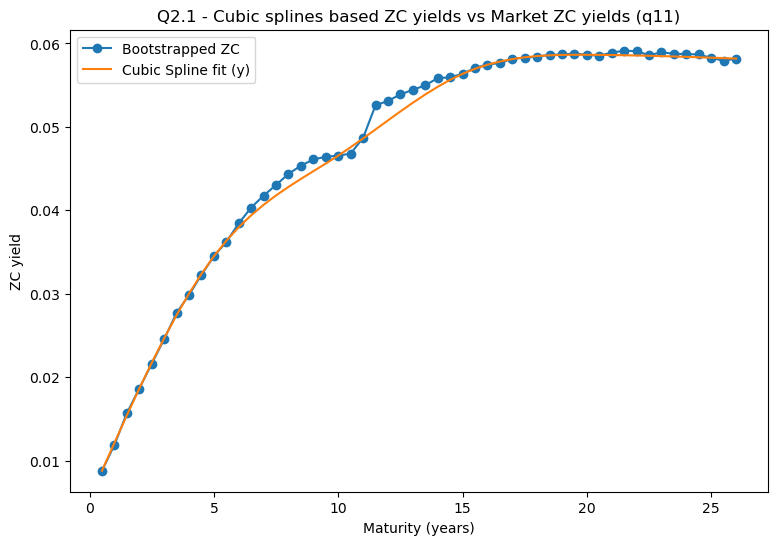

In [10]:
# Results

knots = [2.0, 5.0, 10.0, 15.0, 20.0]
spl = cubic_spline(mkt_zc["T"].values, mkt_zc["y_zc"].values, knots)

plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", linestyle="-", label="Bootstrapped ZC")
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl), linestyle="-", label="Cubic Spline fit (y)")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.savefig("q21_spline_vs_bootstrapped_zc.png")
plt.title("Q2.1 - Cubic splines based ZC yields vs Market ZC yields (q11)")
plt.show()

# Q2.2

Discuss when using those new ‘spline-based’ zero-coupon yields estimates instead of the 
one implied by the bootstrapped zero-coupon bonds in Q1.1 is appropriate. 

Please justify and discuss whether this affects the conclusions reached in Q1.2?

In [11]:
q22 = """
Using spline-based zero-coupon yields instead of the bootstrapped ones is appropriate 
when a smooth and continuous yield curve is required for applications such as bond 
pricing, risk management, or sensitivity analysis. The bootstrapped curve, while fully 
consistent with market bond prices, can sometimes display small irregularities caused by 
discrete maturities, data noise, or rounding in quoted prices. The spline interpolation 
removes these local inconsistencies and produces a term structure that behaves more 
realistically between observed maturities. This makes the spline approach particularly 
suitable for valuing instruments with cash flows that do not match the maturities of the 
underlying bonds, or for calculating key rate durations and forward rates.

However, using spline-based yields means slightly moving away from the exact market 
consistency of the bootstrapped curve. The spline curve smooths out minor differences 
that might represent actual pricing information, so it should be viewed as a convenient 
analytical approximation rather than a perfect market replica.

Regarding the conclusions from Q1.2, the comparison between the market and Deutsche 
Bank’s model zero-coupon yields would not fundamentally change. The spline-based curve 
follows the same general shape as the bootstrapped curve, and the relative differences 
between market and model yields remain essentially the same. At most, the smoothing 
might reduce very small discrepancies at certain maturities, but it would not alter the 
overall buy and sell recommendations. Therefore, while the spline improves the curve’s 
smoothness and usability, it does not materially affect the economic interpretation 
of Q1.2.
"""
print(q22)


Using spline-based zero-coupon yields instead of the bootstrapped ones is appropriate 
when a smooth and continuous yield curve is required for applications such as bond 
pricing, risk management, or sensitivity analysis. The bootstrapped curve, while fully 
consistent with market bond prices, can sometimes display small irregularities caused by 
discrete maturities, data noise, or rounding in quoted prices. The spline interpolation 
removes these local inconsistencies and produces a term structure that behaves more 
realistically between observed maturities. This makes the spline approach particularly 
suitable for valuing instruments with cash flows that do not match the maturities of the 
underlying bonds, or for calculating key rate durations and forward rates.

However, using spline-based yields means slightly moving away from the exact market 
consistency of the bootstrapped curve. The spline curve smooths out minor differences 
that might represent actual pricing information, s

# Q2.3

Re-estimate the cubic splines’ function only using as knots 5- and 20-year zero-coupon 
yields. Plot the discount function against the one obtained in Q2.1. 

Discuss how changing the knots affects the estimated discount function.

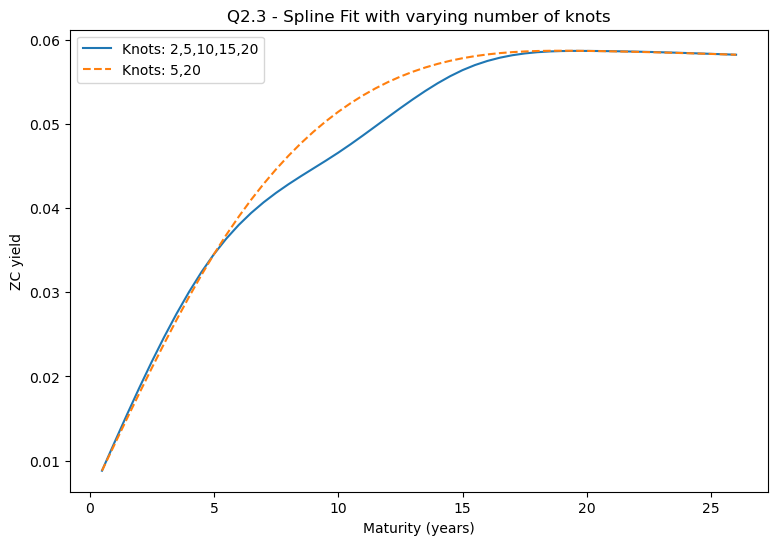

In [12]:
# -- spline 1 : knots 2,5,10,15,20 => see Q2.1 above

# -- spline 2 : knots 5,20
spl_2_knots_only = cubic_spline(mkt_zc["T"].values, mkt_zc["y_zc"].values, [5.0, 20.0])
_eval_natural_cubic(mkt_zc["T"], spl_2_knots_only)

plt.figure()
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl), label="Knots: 2,5,10,15,20") # from Q2.1
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl_2_knots_only), label="Knots: 5,20", linestyle="--")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q2.3 - Spline Fit with varying number of knots")
plt.savefig("q23_spline_knots_number.png")
plt.show()

# Q3 Nelson Siegel model

# Q3.1

Estimate the discount function according to the Nelson-Siegel-Svensson model. 

Describe succinctly  the  methodology  and  document  any  choice  made  in  the  estimation (see pdf doc).

Plot  it against the zero-coupon yields obtained in Q1.1.

In [13]:
## Helper functions

# Helper function: NSS factor loadings
def NSS_loadings(T, tau1, tau2):
    T = np.asarray(T, float)
    t1 = T / max(tau1, 1e-6)
    t2 = T / max(tau2, 1e-6)
    # Avoid division by zero: for T=0, we take the limit (1 - e^{-x})/x -> 1
    S  = (1 - np.exp(-t1)) / np.where(T == 0.0, 1.0, t1)
    C1 = S - np.exp(-t1)
    S2 = (1 - np.exp(-t2)) / np.where(T == 0.0, 1.0, t2)
    C2 = S2 - np.exp(-t2)
    L  = np.ones_like(T)
    return np.column_stack([L, S, C1, C2])  # columns: Level, Slope, Curv1, Curv2

# Helper function: fit NSS model to data
def NSS(T, y, init=None):
    """
    Grid-search on (tau1, tau2), OLS closed form for (beta0..beta3) via lstsq.
    Returns:
      params: dict {beta0..beta3, tau1, tau2}
      yhat:   np.ndarray predictions at given T
    """
    T = np.asarray(T, float)
    y = np.asarray(y, float)

    # simple grid (course) — adjust if needed
    tau1_grid = np.linspace(0.5, 5.0, 20)
    tau2_grid = np.linspace(5.0, 15.0, 20)

    best_sse = np.inf
    best = None

    for tau1 in tau1_grid:
        for tau2 in tau2_grid:
            X = NSS_loadings(T, tau1, tau2)
            beta, *_ = np.linalg.lstsq(X, y, rcond=None)
            yhat = X @ beta
            sse = float(np.sum((y - yhat) ** 2))
            if sse < best_sse:
                best_sse = sse
                best = (beta, tau1, tau2, yhat)

    b0, b1, b2, b3 = best[0]
    params = {
        "beta0": b0, "beta1": b1, "beta2": b2, "beta3": b3,
        "tau1":  best[1], "tau2":  best[2],
    }
    yhat = best[3]
    return params, yhat

NSS parameters (betas and taus):
 {'beta0': -0.07002221109457317, 'beta1': 0.07369065209867683, 'beta2': 0.05376197292687927, 'beta3': 0.37380969341552284, 'tau1': 3.3421052631578947, 'tau2': 15.0}

NSS fitted yields:
 [0.00815658 0.01219122 0.01583706 0.0191484  0.02217076 0.02494231
 0.02749501 0.0298556  0.03204647 0.03408636 0.03599093 0.03777334
 0.03944458 0.04101392 0.04248913 0.0438768  0.04518252 0.04641104
 0.04756645 0.04865229 0.04967165 0.05062725 0.05152151 0.05235662
 0.05313457 0.05385721 0.05452623 0.05514327 0.05570986 0.05622747
 0.05669752 0.05712141 0.05750048 0.05783605 0.05812942 0.05838188
 0.05859468 0.05876907 0.05890628 0.05900752 0.05907398 0.05910686
 0.0591073  0.05907647 0.05901548 0.05892545 0.05880747 0.0586626
 0.05849191 0.05829642 0.05807714 0.05783505]


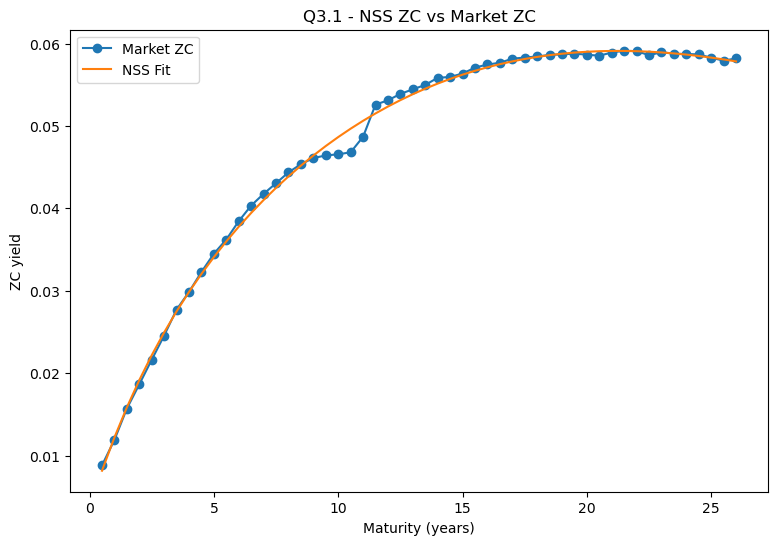

In [14]:
## Results

betas_taus = NSS(mkt_zc["T"].values, mkt_zc["y_zc"].values, init=None)[0]
print("NSS parameters (betas and taus):\n", betas_taus)
y_hat_nss = NSS(mkt_zc["T"].values, mkt_zc["y_zc"].values, init=None)[1]
print("\nNSS fitted yields:\n", y_hat_nss)

plt.figure()
plt.plot(mkt_zc["T"], mkt_zc["y_zc"], marker="o", linestyle="-", label="Market ZC")
plt.plot(mkt_zc["T"], y_hat_nss, linestyle="-", label="NSS Fit")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q3.1 - NSS ZC vs Market ZC")
plt.savefig("q31_nss_vs_market_zc.png")
plt.show()

# Q3.2

Compare the fit of the two models from Q2.1 and Q3.1.  

Discuss the differences (see pdf doc).

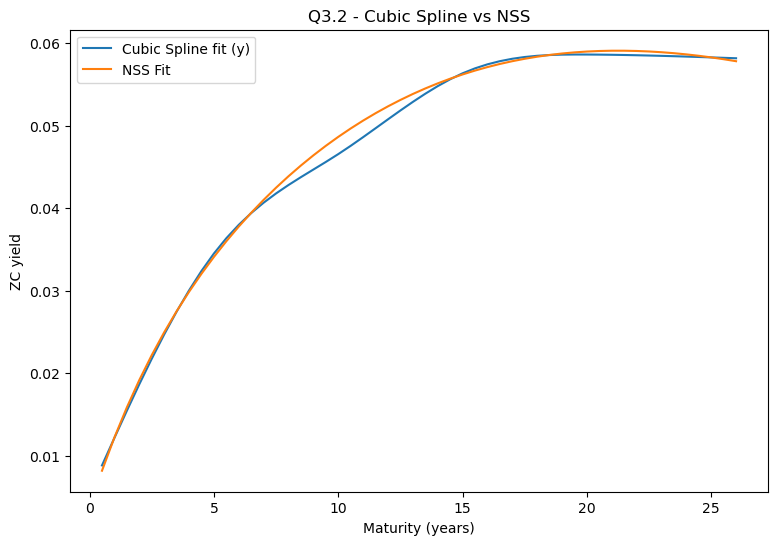

In [15]:
# Comparison spline vs NSS

plt.figure()
plt.plot(mkt_zc["T"], _eval_natural_cubic(mkt_zc["T"], spl), linestyle="-", label="Cubic Spline fit (y)")
plt.plot(mkt_zc["T"], y_hat_nss, linestyle="-", label="NSS Fit")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q3.2 - Cubic Spline vs NSS")
plt.savefig("q32_spline_vs_nss.png")
plt.show()


# Q3.3

Estimate and plot the factor loadings and contributions from the different factors affecting the shape of the spot zero-coupon curve.  

Explain their key drivers (see pdf doc).

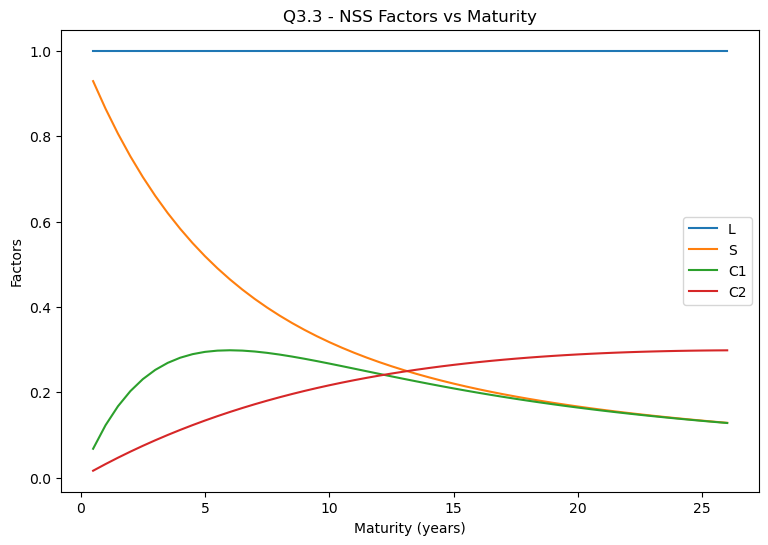

In [16]:
## NSS factors vs Maturity

X = NSS_loadings(T, betas_taus["tau1"], betas_taus["tau2"])
factors=pd.DataFrame({
    "T": np.asarray(T, float),
    "Level":      X[:, 0],
    "Slope":      X[:, 1],
    "Curvature1": X[:, 2],
    "Curvature2": X[:, 3],
    })

plt.figure()
plt.plot(factors["T"], factors["Level"], label="L")
plt.plot(factors["T"], factors["Slope"], label="S")
plt.plot(factors["T"], factors["Curvature1"], label="C1")
plt.plot(factors["T"], factors["Curvature2"], label="C2")
plt.xlabel("Maturity (years)")
plt.ylabel("Factors")
plt.legend()
plt.title("Q3.3 - NSS Factors vs Maturity")
plt.savefig("q33_nss_factors.png")
plt.show()

# Q4 Hedging

# Q4.1

To estimate the sensitivity of any instrument or portfolio to the 10-year rate changes, i.e., its  10-year  key  rate  duration  (KRD),  you  will  shock  the  10-year  rate  by  50bps.  

Discuss what the impact is on the zero coupon yield curve estimated in Q2.1? (see pdf)

Plot the difference.

In [17]:
## Helper functions

# Helper function: nb of years between two dates according to day count convention
def yearfrac(start, end, day_count="ACT/ACT"):
    a = pd.Timestamp(start); b = pd.Timestamp(end)
    days = (b - a).days
    if str(day_count).upper() in ("ACT/365", "ACT/365F"):
        return days / 365.0
    return days / 365.0  # simple ACT/ACT

# Helper function: nbr of periods between settlement and maturity
def _regular_schedule(settlement, maturity, freq):
    # regular grid from settlement (approx) to maturity
    T = yearfrac(settlement, maturity)
    n = max(1, int(round(T * freq)))
    return np.arange(1, n+1, dtype=float) / float(freq)

# Helper function: price bond from discount curve
def price_bond_from_curve(settlement, maturity_date, coupon_rate, frequency, face, day_count, df_func):
    settlement = pd.Timestamp(settlement); maturity_date = pd.Timestamp(maturity_date)
    freq = int(frequency)
    cpn = _clean_coupon_rate(coupon_rate) * face / freq
    T = _regular_schedule(settlement, maturity_date, freq)
    D = df_func(T)
    return float(np.dot(np.full_like(T, cpn, dtype=float), D) + face * D[-1])

# Helper function: portfolio key rate duration
def portfolio_krd(bonds_df, settlement, key_maturities, shock_bps=50,
                  base_df_func=None, comp="cont", day_count="ACT/ACT"):
    keys = np.asarray(key_maturities, float)
    shock = float(shock_bps) / 1e4  # 50 bps -> 0.005

    def _y_base(t):
        t = np.asarray(t, float)
        return zc_yield_from_df(base_df_func(t), t, comp)

    rows = []
    width = 0.50  # local width (years) of the key bump
    for k in keys:
        def bumped_df_func(t):
            t = np.asarray(t, float)
            yb = _y_base(t) + shock * np.exp(-0.5*((t - k)/width)**2)
            return df_from_zc_yield(yb, t, comp)

        # ΔP/P weighted by 'weight' if present, otherwise equally weighted
        rel_changes, weights = [], []
        for _, r in bonds_df.iterrows():
            face = float(r.get("face", default=100.0))
            P0 = price_bond_from_curve(settlement, r["maturity_date"], r["coupon_rate"],
                                       int(r.get("frequency", 2)), face, day_count, base_df_func)
            P1 = price_bond_from_curve(settlement, r["maturity_date"], r["coupon_rate"],
                                       int(r.get("frequency", 2)), face, day_count, bumped_df_func)
            w = float(r.get("weight", 1.0))
            rel_changes.append((P1 - P0) / P0)
            weights.append(w)
        weights = np.asarray(weights, float)
        rel_changes = np.asarray(rel_changes, float)
        wsum = weights.sum() if weights.sum()!=0 else len(weights)
        rel_port = float((weights * rel_changes).sum() / wsum)
        krd = - rel_port / shock
        rows.append({"key_maturity": k, "KRD": krd})
    return pd.DataFrame(rows)



KRDs:
    key_maturity       KRD
0           2.0  0.101136
1           5.0  0.009168
2          10.0 -0.000000
3          15.0 -0.000000
4          20.0 -0.000000


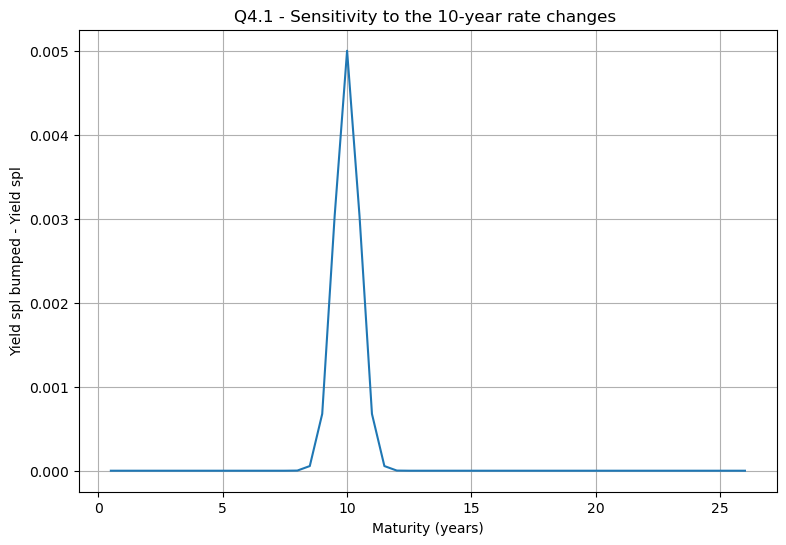

In [18]:
# KRD calculation
key_maturities = [2.0, 5.0, 10.0, 15.0, 20.0]
original_spl_df_func = lambda T: df_from_zc_yield(
    _eval_natural_cubic(T, spl), T, COMPOUNDING) 
krd_df = portfolio_krd(bonds, SETTLEMENT_DATE, key_maturities,
                       shock_bps=50, base_df_func=original_spl_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)
print("KRDs:\n", krd_df)
krd_df.to_csv("q40_portfolio_krd.csv", index=False) 

# Sensitivity analysis to 10-year rate changes
width = 0.50 # local width (years) of the key bump
bump = 0.0050  # 50 bps
weights = np.exp(-0.5 * ((mkt_zc["T"] - 10.0) / width)**2) # Gaussian weights centered at 10 years

#  use the evaluator on the coeffs from Q2.1 (spline with knots 2,5,10,15,20)
y_original_spl = _eval_natural_cubic(mkt_zc["T"], spl)
y_spl_bump50bps = y_original_spl + bump * weights

plt.figure()
plt.plot(mkt_zc["T"], y_spl_bump50bps - y_original_spl)
plt.xlabel("Maturity (years)")
plt.ylabel("Yield spl bumped - Yield spl")
plt.title("Q4.1 - Sensitivity to the 10-year rate changes ")
plt.grid(True)
plt.savefig("q41_sensitivity_10y_rate.png")
plt.show()


# Q4.2

Assume you own a 1 million $ portfolio that is equally invested in all bonds. 

What is the KRD of your portfolio to this scenario?  

Describe your approach to estimating this exposure.

In [19]:
# KRD of my 1 million $ portfolio that is equally invested in all bonds

# Create portfolio with equal weights
my_ptfo = bonds.copy()

# Frequency par défaut = mode si dispo sinon 2
if "frequency" in my_ptfo.columns and my_ptfo["frequency"].notna().any():
    FREQ_DEFAULT = int(my_ptfo["frequency"].dropna().astype(int).mode().iloc[0])
else:
    FREQ_DEFAULT = 2

# create/clean frequency column
if "frequency" not in my_ptfo.columns:
    my_ptfo["frequency"] = FREQ_DEFAULT
else:
    my_ptfo["frequency"] = my_ptfo["frequency"].fillna(FREQ_DEFAULT).astype(int)

# Face & id par défaut si manquent
if "face" not in my_ptfo.columns:
    my_ptfo["face"] = 100.0
if "id" not in my_ptfo.columns:
    my_ptfo["id"] = np.arange(1, len(my_ptfo) + 1)

# Equal weights for total 1,000,000 $
n = len(my_ptfo)
my_ptfo["weight"] = 1_000_000.0 / n

# KRD calculation for my portfolio
krd_10y = portfolio_krd(my_ptfo, SETTLEMENT_DATE, key_maturities=np.array([10.0]), shock_bps=50,
                       base_df_func=original_spl_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)
print(krd_10y)
krd_10y.to_csv("q42_my_portfolio_krd.csv", index=False)


   key_maturity  KRD
0          10.0 -0.0


# Q4.3

Estimate  and  plot  the  KRDs  of  your  portfolio  for all  maturities,  when applying  the  same shock individually to all zero-coupon yields. 

Plot and interpret the results.

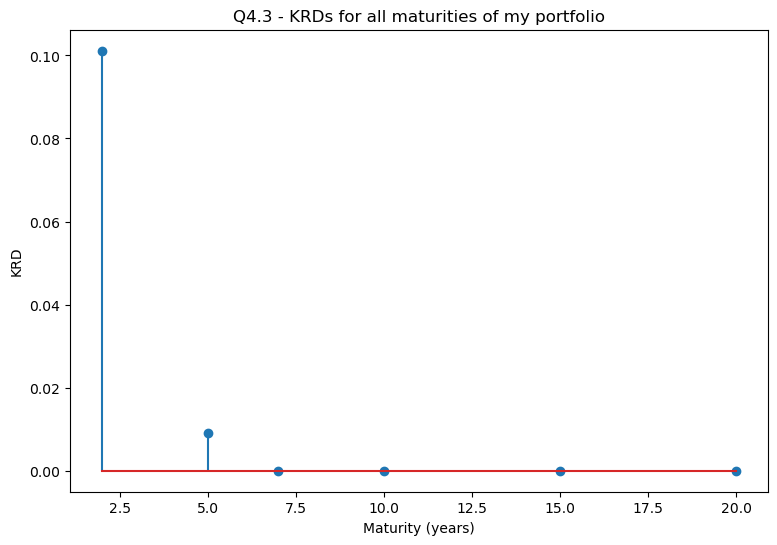

In [20]:
# Full KRD profile
keys = np.array([2.0, 5.0, 7.0, 10.0, 15.0, 20.0])
krd_all_maturities = portfolio_krd(my_ptfo, SETTLEMENT_DATE, key_maturities=keys, shock_bps=50,
                        base_df_func=original_spl_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)


plt.figure()
plt.stem(krd_all_maturities["key_maturity"], krd_all_maturities["KRD"])
plt.xlabel("Maturity (years)")
plt.ylabel("KRD")
plt.title("Q4.3 - KRDs for all maturities of my portfolio")
plt.savefig("q43_my_portfolio_krd_profile.png")
plt.show()


# Q.5 Portfolio strategy

# Q5.1

You expect the bootstrapped zero-coupon curve from Q1.2 to steepen according to the 
following function, where 𝜀 is a random noise and 𝑇̅ is the average bond maturity in your 
sample: 
 
𝑦𝑆𝑡𝑒𝑒𝑝𝑒𝑛𝑇 =𝑦𝑇 +[(𝑇−𝑇̅)/𝑇̅∗0.0050]+𝜀 
𝜀~𝑁(0,0.0025) 
 
Plot the new curve according to your expectations against the bootstrapped zero-coupon.   

Split the deterministic component of your expectation from the stochastic one originating from the random noise 𝜀 term.

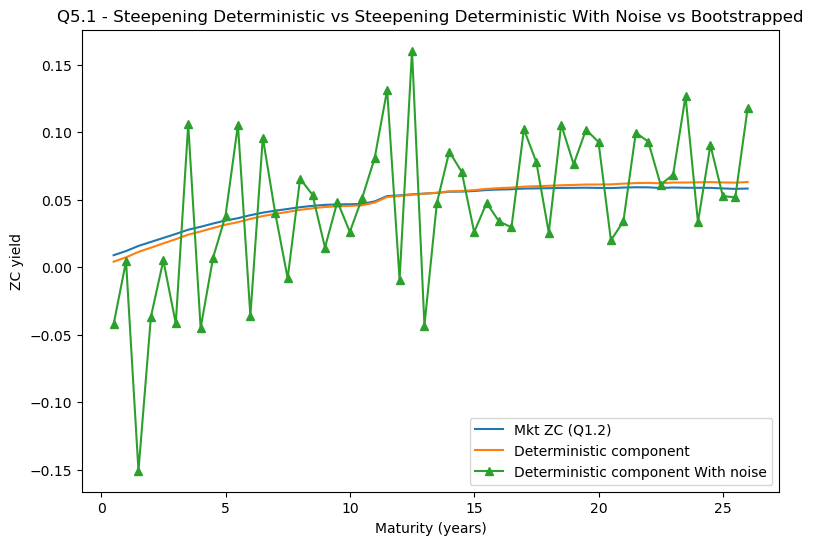

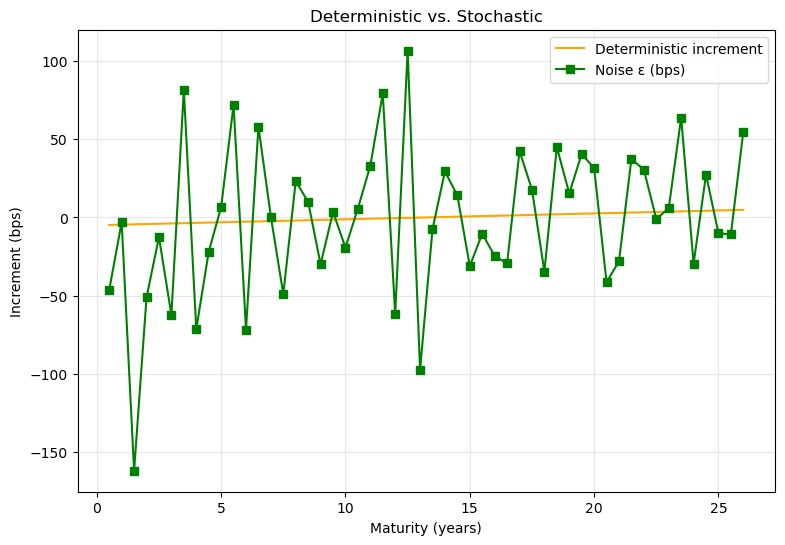

In [30]:
# Steepening deterministic component
y_original_mkt = mkt_zc["y_zc"].values
T = mkt_zc["T"].values
T_average = mkt_zc["T"].values.mean()
y_new_steep_det = y_original_mkt + ((T - T_average)/T_average)*0.0050

# Generate random noise for the steepening scenario
eps = np.random.normal(loc=0.0, scale=np.sqrt(0.0025), size=len(T))
# Steepening deterministic component with noise
y_new_steep_det_noise = y_new_steep_det + eps

# Plot comparison
plt.figure()
plt.plot(mkt_zc["T"], y_original_mkt, linestyle="-", label="Mkt ZC (Q1.2)")
plt.plot(mkt_zc["T"], y_new_steep_det, linestyle="-", label="Deterministic component")
plt.plot(mkt_zc["T"], y_new_steep_det_noise, marker="^", linestyle="-", label="Deterministic component With noise")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q5.1 - Steepening Deterministic vs Steepening Deterministic With Noise vs Bootstrapped")
plt.savefig("q51_steepening_deterministic_vs_noise.png")
plt.show()

# Plot comparison shift only
plt.plot(mkt_zc["T"], (y_new_steep_det - y_original_mkt)*1000, linestyle="-", color="orange", label="Deterministic increment")
plt.plot(mkt_zc["T"], eps*1000, marker="s", linestyle="-", color="green", label="Noise ε (bps)")
plt.title("Deterministic vs. Stochastic")
plt.xlabel("Maturity (years)")
plt.ylabel("Increment (bps)")
plt.grid(True, alpha=0.3)
plt.savefig("q51_deterministic_vs_stochastic.png")
plt.legend()


# Q5.2

Re-estimate  the  discount function  using  the  Nelson-Siegel-Svensson  methodology, 
applied in  Q3.1.  

Value  all  coupon  paying bonds  accordingly and  identify  the  cheap and expensive bonds given their current market prices. 

Discuss (see pdf).

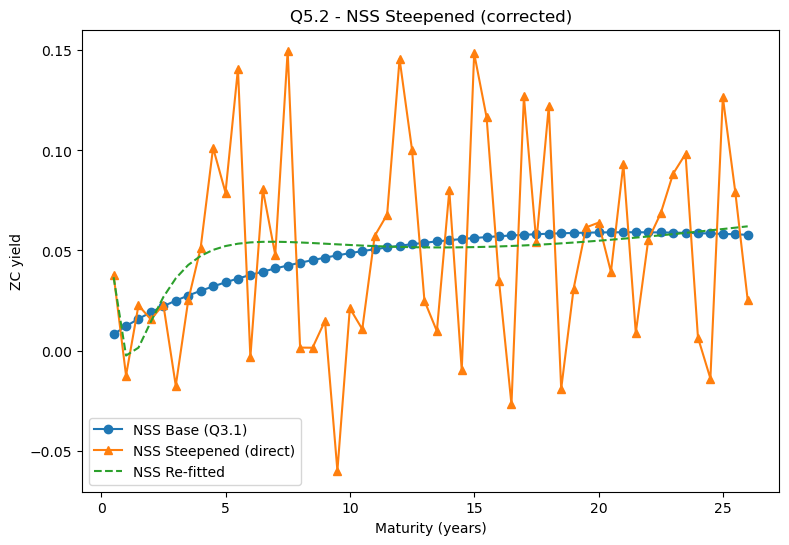

In [ ]:
# 1. Retrieve the yields NSS from Q3.1 (already smooth)
y_nss_base = y_hat_nss  # from Q3.1

# 2. Apply the deterministic steepening + noise
T_bar = float(np.mean(T))
eps = np.random.normal(loc=0.0, scale=np.sqrt(0.0025), size=len(T))
y_stp_from_nss = y_nss_base + ((T - T_bar) / T_bar) * 0.0050 + eps

# 3. Re-fit NSS on this steepened curve (optional, or keep y_stp_from_nss directly)
betas_taus_stp = NSS(T, y_stp_from_nss)[0]
y_hat_stp = NSS(T, y_stp_from_nss)[1]

# Plot
plt.figure()
plt.plot(mkt_zc["T"], y_nss_base, marker="o", label="NSS Base (Q3.1)")
plt.plot(mkt_zc["T"], y_stp_from_nss, marker="^", label="NSS Steepened (direct)")
plt.plot(mkt_zc["T"], y_hat_stp, linestyle="--", label="NSS Re-fitted")
plt.xlabel("Maturity (years)")
plt.ylabel("ZC yield")
plt.legend()
plt.title("Q5.2 - NSS Steepened (corrected)")
plt.savefig("q52_nss_steepened_corrected.png")
plt.show()



Bond Valuation under Steepened Curve:
    id   mkt_price  stp_nss_price  stpnss_minus_mkt signal
46  47  107.480543     109.661982          2.181439    Buy
45  46  105.512905     106.946017          1.433112    Buy
47  48  108.848154     109.751169          0.903015    Buy
48  49  109.655826     108.512322         -1.143505   Sell
2    3  100.307693      98.920953         -1.386739   Sell
1    2  100.618821      99.227780         -1.391041   Sell
5    6  100.743272      99.350511         -1.392761   Sell
0    1  101.054400      99.657338         -1.397062   Sell
8    9  101.054400      99.657338         -1.397062   Sell
7    8  101.178851      99.780068         -1.398783   Sell
9   10  101.178851      99.780068         -1.398783   Sell
18  19  101.489979     100.086895         -1.403084   Sell
19  20  101.676656     100.270991         -1.405665   Sell
17  18  101.738882     100.332357         -1.406525   Sell
16  17  101.987784     100.577818         -1.409966   Sell
15  16  102.05001

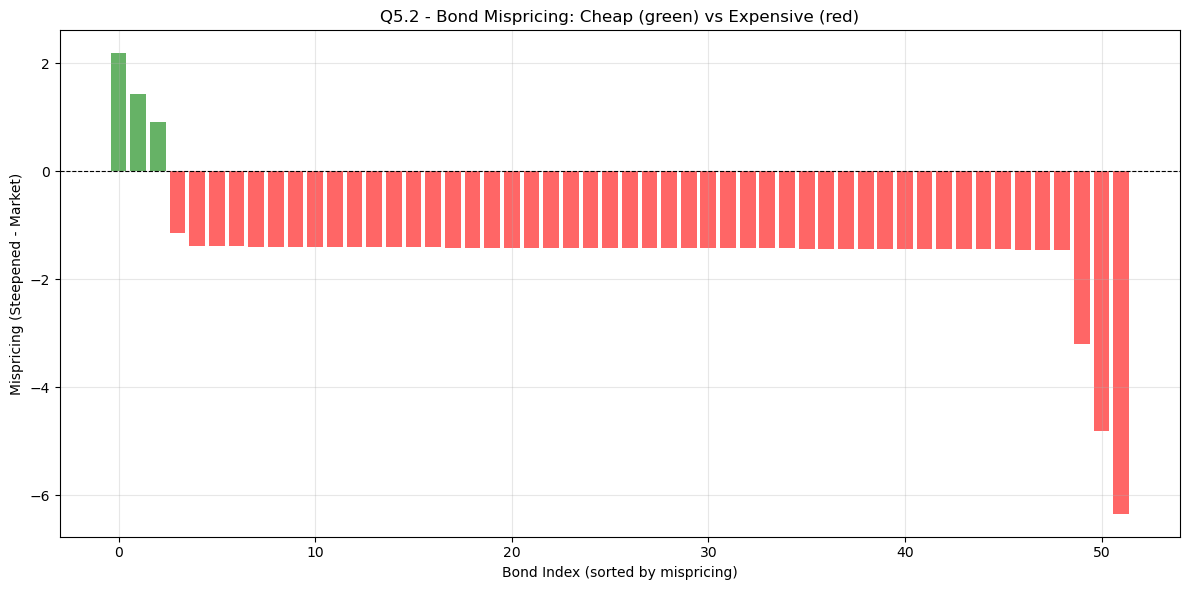

In [36]:
# Value all coupon paying bonds using the steepened NSS curve

# Create discount function from steepened NSS parameters
def df_func_nss_stp(t):
    t_arr = np.asarray(t, float)
    loadings = NSS_loadings(t_arr, betas_taus_stp["tau1"], betas_taus_stp["tau2"])
    y_stp_nss = loadings @ np.array([
        betas_taus_stp["beta0"], 
        betas_taus_stp["beta1"],
        betas_taus_stp["beta2"], 
        betas_taus_stp["beta3"]
    ])
    return df_from_zc_yield(y_stp_nss, t_arr, COMPOUNDING)

# Create discount function from market ZC yields
def df_func_mkt(t):
    t_arr = np.asarray(t, float)
    y_interp = np.interp(t_arr, mkt_zc["T"].values, mkt_zc["y_zc"].values)
    return df_from_zc_yield(y_interp, t_arr, COMPOUNDING)

# Value each bond under both scenarios
valuation_results = []
for idx, bond in bonds.iterrows():
    bond_id = bond.get("id", idx + 1)
    maturity = bond["maturity_date"]
    coupon = bond["coupon_rate"]
    face_val = bond.get("face", 100.0)
    freq_val = int(bond.get("frequency", 2))
    
    # Market price (current)
    price_mkt = price_bond_from_curve(
        SETTLEMENT_DATE, maturity, coupon, freq_val, face_val, DAY_COUNT, df_func_mkt
    )
    
    # Steepened NSS price (expected)
    price_stp = price_bond_from_curve(
        SETTLEMENT_DATE, maturity, coupon, freq_val, face_val, DAY_COUNT, df_func_nss_stp
    )
    
    # Mispricing: positive means bond is cheap (steepened price > market price)
    mispricing = price_stp - price_mkt
    
    valuation_results.append({
        "id": bond_id,
        "mkt_price": price_mkt,
        "stp_nss_price": price_stp,
        "stpnss_minus_mkt": mispricing,
        "signal": "Buy" if mispricing > 0 else "Sell"
    })

# Create DataFrame and sort by mispricing
df_vals = pd.DataFrame(valuation_results).sort_values("stpnss_minus_mkt", ascending=False)
print("\nBond Valuation under Steepened Curve:")
print(df_vals)
df_vals.to_csv("q52_steepened_nss_bond_valuation.csv", index=False)

# Summary statistics
cheap_bonds = df_vals[df_vals["stpnss_minus_mkt"] > 0]
expensive_bonds = df_vals[df_vals["stpnss_minus_mkt"] < 0]

print(f"\nCheap bonds (Buy): {len(cheap_bonds)} bonds")
print(f"Expensive bonds (Sell): {len(expensive_bonds)} bonds")
print(f"\nAverage mispricing (cheap): {cheap_bonds['stpnss_minus_mkt'].mean():.4f}")
print(f"Average mispricing (expensive): {expensive_bonds['stpnss_minus_mkt'].mean():.4f}")

# Visualization
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in df_vals["stpnss_minus_mkt"]]
plt.bar(range(len(df_vals)), df_vals["stpnss_minus_mkt"], color=colors, alpha=0.6)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xlabel("Bond Index (sorted by mispricing)")
plt.ylabel("Mispricing (Steepened - Market)")
plt.title("Q5.2 - Bond Mispricing: Cheap (green) vs Expensive (red)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("q52_bond_mispricing.png")
plt.show()

# Q5.3

Propose  a  diversified  zero-cost  long-short  portfolio  strategy  that  aims  at  harvesting  the mispricing identified in the previous questions.  

Assume your initial wealth is 100$ and your financing  costs  are  null.  How  much  should  you  invest  in  which  bonds?  What  is  your expected return? 

    id action   mkt_price  stp_nss_price  allocation_usd  expected_return_pct
0   47    Buy  107.480543     109.661982       16.666667             0.020296
1   46    Buy  105.512905     106.946017       16.666667             0.013582
2   48    Buy  108.848154     109.751169       16.666667             0.008296
3   49   Sell  109.655826     108.512322       -1.020408            -0.010428
4    3   Sell  100.307693      98.920953       -1.020408            -0.013825
5    2   Sell  100.618821      99.227780       -1.020408            -0.013825
6    6   Sell  100.743272      99.350511       -1.020408            -0.013825
7    1   Sell  101.054400      99.657338       -1.020408            -0.013825
8    9   Sell  101.054400      99.657338       -1.020408            -0.013825
9    8   Sell  101.178851      99.780068       -1.020408            -0.013825
10  10   Sell  101.178851      99.780068       -1.020408            -0.013825
11  19   Sell  101.489979     100.086895       -1.020408        

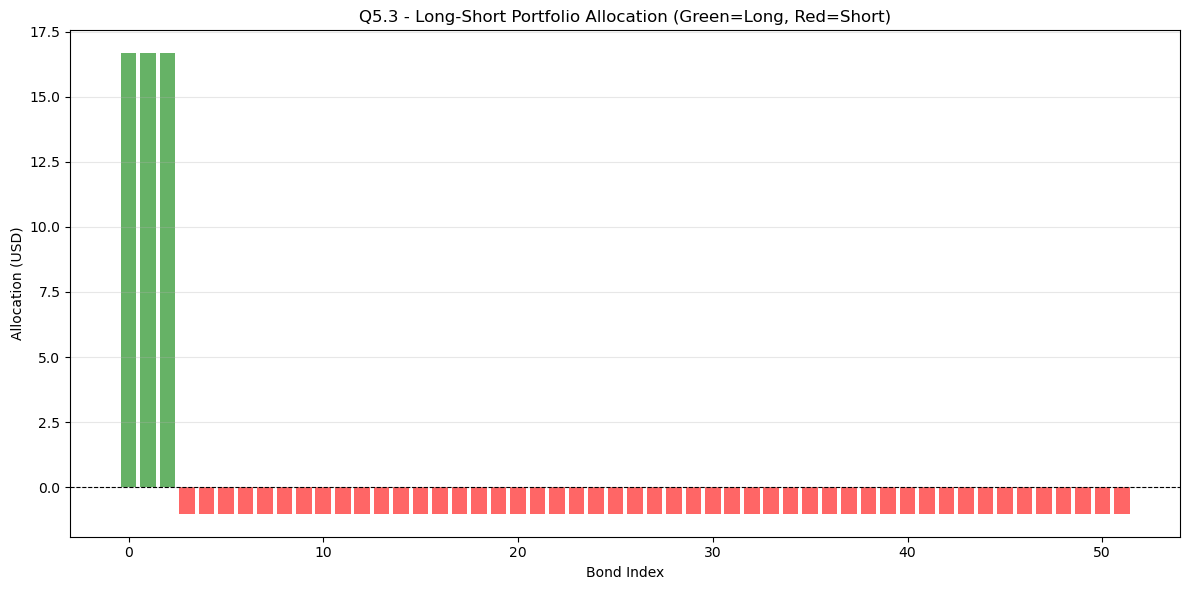

In [ ]:
# Long-short portfolio construction

from typing import Tuple

def build_long_short_portfolio(data: pd.DataFrame, starting_capital: float = 100.0) -> Tuple[pd.DataFrame, float]:
    """
    Build a balanced long-short portfolio (50% long / 50% short) from the provided DataFrame.

    Required input columns:
      - "id"
      - "mkt_price"
      - "stp_nss_price"
      - "stpnss_minus_mkt"     (signal: >0 => go long, <0 => go short)

    Returns:
      - portfolio DataFrame with allocation and contribution columns
      - expected portfolio return as a fraction (e.g. 0.012 = 1.2%)
    """
    # Split candidates into longs and shorts
    longs = data.loc[data["stpnss_minus_mkt"] > 0].copy()
    shorts = data.loc[data["stpnss_minus_mkt"] < 0].copy()

    if longs.empty or shorts.empty:
        raise ValueError("All long or all short positions; cannot build balanced portfolio.")

    # Counts per side
    num_longs = len(longs)
    num_shorts = len(shorts)

    # Gross exposure split evenly between long and short
    gross_exposure = starting_capital
    long_notional = gross_exposure / 2.0
    short_notional = gross_exposure / 2.0

    # Per-asset allocation in USD (short allocations are negative)
    longs.loc[:, "allocation_usd"] = long_notional / num_longs
    shorts.loc[:, "allocation_usd"] = - (short_notional / num_shorts)
    
    # Add action column
    longs.loc[:, "action"] = "Buy"
    shorts.loc[:, "action"] = "Sell"

    # Expected return per asset (percentage)
    longs.loc[:, "expected_return_pct"] = (longs["stp_nss_price"] - longs["mkt_price"]) / longs["mkt_price"]
    shorts.loc[:, "expected_return_pct"] = (shorts["stp_nss_price"] - shorts["mkt_price"]) / shorts["mkt_price"]

    # Combine and compute contributions
    portfolio = pd.concat([longs, shorts], ignore_index=True)
    portfolio.loc[:, "weight_usd"] = portfolio["allocation_usd"]
    portfolio.loc[:, "contribution_usd"] = portfolio["weight_usd"] * portfolio["expected_return_pct"]

    # Aggregate expected return
    total_expected_return_usd = portfolio["contribution_usd"].sum()
    total_expected_return_pct = total_expected_return_usd / starting_capital

    return portfolio, total_expected_return_pct

# Build and display long-short portfolio
sample_df = df_vals.copy()
portfolio_df, expected_return = build_long_short_portfolio(sample_df, starting_capital=100.0)
print(portfolio_df[["id", "action", "mkt_price", "stp_nss_price", "allocation_usd", "expected_return_pct"]])
print(f"Expected portfolio return ≈ {expected_return:.2%}")

# Visualization - Allocation par obligation
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in portfolio_df["allocation_usd"]]
plt.bar(range(len(portfolio_df)), portfolio_df["allocation_usd"], color=colors, alpha=0.6)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xlabel("Bond Index")
plt.ylabel("Allocation (USD)")
plt.title("Q5.3 - Long-Short Portfolio Allocation (Green=Long, Red=Short)")
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("q53_long_short_allocation.png")
plt.show()